In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from scipy.stats import pearsonr

# ------------------------------------------------------------------
# 1. Parameter set‑up
# ------------------------------------------------------------------
np.random.seed(42)                       # reproducibility

# AR coefficients ϕ₁, ϕ₂   (Box–Jenkins sign convention, intuitive)
phi = np.array([0.5, -0.25])
# MA coefficients θ₁, θ₂
theta = np.array([0.4, 0.3])

p, q = len(phi), len(theta)
n_obs = 365
burnin = 200                             # extra steps so start‑up transients die out

# ------------------------------------------------------------------
# 2. Hand‑rolled ARMA simulation
# ------------------------------------------------------------------
# Generate εₜ  ~  N(0, 1)
eps = np.random.normal(size=n_obs + burnin + max(p, q))

x = np.zeros_like(eps)                   # placeholder for xₜ
for t in range(max(p, q), len(eps)):
    # ---- Autoregressive contribution Σ ϕᵢ xₜ₋ᵢ
    ar_part = np.dot(phi, x[t - np.arange(1, p + 1)])

    # ---- Moving‑average contribution  εₜ + Σ θⱼ εₜ₋ⱼ
    ma_part = eps[t] + np.dot(theta, eps[t - np.arange(1, q + 1)])

    x[t] = ar_part + ma_part

# Drop the burn‑in.
x_manual = x[burnin:]

In [ ]:
# ------------------------------------------------------------------
# 3. Cross‑check with statsmodels’ ArmaProcess
# ------------------------------------------------------------------
# statsmodels expects the polynomial form: ar = [1, −ϕ₁, −ϕ₂] etc.
ar_poly = np.r_[1, -phi]
ma_poly = np.r_[1, theta]
sm_process = ArmaProcess(ar_poly, ma_poly)
x_sm = sm_process.generate_sample(nsample=n_obs)

corr = pearsonr(x_manual[:n_obs], x_sm)[0]
print(f"Correlation between two *independent* realisations of the same ARMA(2,2): {corr:+.2f} (should be near 0)")

Correlation between two *independent* realisations of the same ARMA(2,2): -0.04 (should be near 0)


In [ ]:
# ------------------------------------------------------------------
# 4. Build the ARIMA level series yₜ = Σ xᵢ + deterministic weekly seasonality
# ------------------------------------------------------------------
weekly_cycle = 10 * np.sin(2 * np.pi * np.arange(n_obs) / 7)
y_manual = np.cumsum(x_manual[:n_obs]) + weekly_cycle + 100    # +100: arbitrary offset

In [ ]:
# ------------------------------------------------------------------
# 5. Put into a DataFrame for convenience
# ------------------------------------------------------------------
dates = pd.date_range("2024-01-01", periods=n_obs, freq="D")
data = pd.DataFrame({"epsilon": eps[burnin:burnin + n_obs],
                     "arma_component (x_t)": x_manual[:n_obs],
                     "weekly_cycle": weekly_cycle,
                     "arima_level (y_t)": y_manual},
                    index=dates)

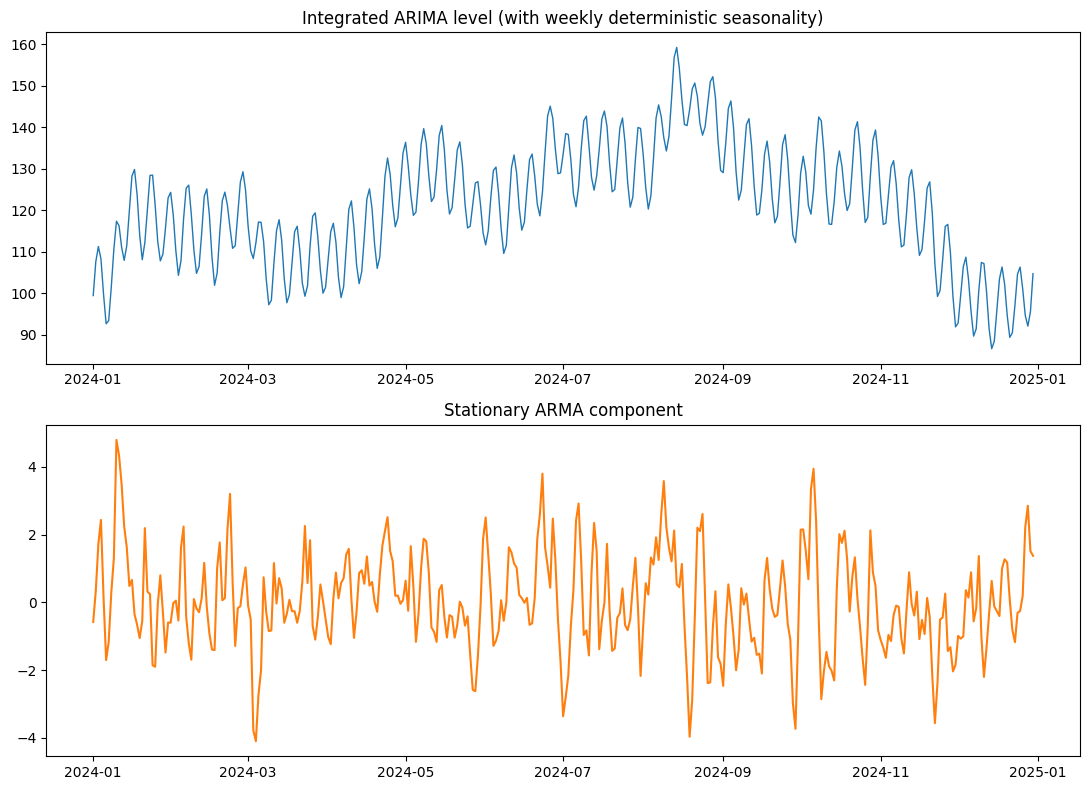

In [ ]:
# ------------------------------------------------------------------
# 6. Plot the pieces
# ------------------------------------------------------------------
fig, axes = plt.subplots(2, 1, figsize=(11, 8)) # Create a figure and a set of subplots

# Swap the order of plotting
axes[0].plot(data["arima_level (y_t)"], label="Integrated ARIMA level $y_t$", linewidth=1)
axes[0].set_title("Integrated ARIMA level (with weekly deterministic seasonality)")
# axes[0].legend()

axes[1].plot(data["arma_component (x_t)"], label="Stationary ARMA component $x_t$", color="C1")
axes[1].set_title("Stationary ARMA component")
# axes[1].legend()


plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [ ]:
# ------------------------------------------------------------------
# 7. Show the first few rows so you can inspect the raw numbers
# ------------------------------------------------------------------
print("\nHead of the simulated DataFrame:")
print(data.head())


Head of the simulated DataFrame:
             epsilon  arma_component (x_t)  weekly_cycle  arima_level (y_t)
2024-01-01  0.357787             -0.576289      0.000000          99.423711
2024-01-02  0.560785              0.341082      7.818315         107.583108
2024-01-03  1.083051              1.729315      9.749279         111.243387
2024-01-04  1.053802              2.434645      4.338837         108.267590
2024-01-05 -1.377669              0.153760     -4.338837          99.743676
